Giorgio Mendoza

RBE595-S24-S04

Model-based RL Programming Exercise

The following code implements the Dyna-Q algorithm to solve the Dyna Maze problem. The key components of the code are:

###MazeEnvironment Class:
This class models the maze environment. It includes methods to:


###step:
Transition to the next state based on the agent's action. If the action leads to an obstacle or out-of-bounds, the state does not change.
reset: Reset the environment to the starting state.
Action Selection: The epsilon_greedy_action_selection function chooses actions based on the epsilon-greedy policy, balancing exploration and exploitation.


###Q-Value Update:
The q_learning_update function updates the Q-values using the standard Q-learning formula, considering the reward received and the estimated value of the next state.

###Planning:
The planning function simulates experiences using the learned model to further update the Q-values, which accelerates the learning process.

###Simulation Loop:
The simulation runs for a defined number of episodes. In each episode, the agent interacts with the environment, updates the Q-values, updates the model, and performs a number of planning steps.

###Resetting:
Between simulations with different numbers of planning steps, the Q-values and Model are reset to ensure independent learning curves.

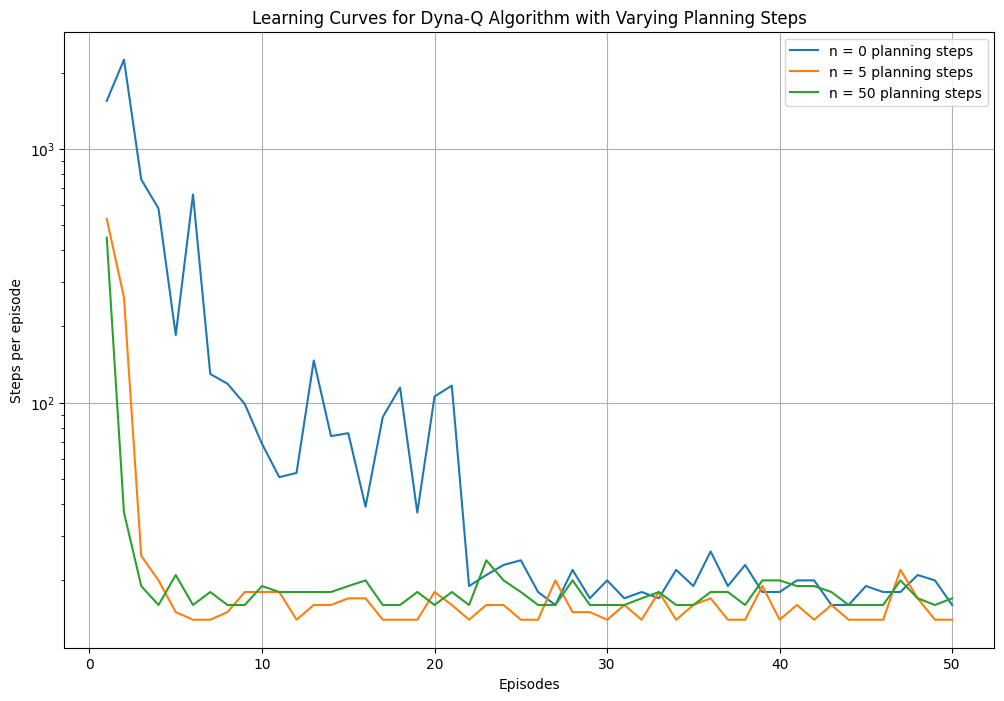

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define the gray squares' positions (obstacles in the maze)
gray_squares = [(4, 2), (3, 2), (2, 2), (1, 5), (5, 7), (4, 7), (3, 7)]

# Define the start and goal positions
start_pos = (3, 0)  # Start at (3,0)
goal_pos = (5, 8)   # Goal at (5,8)

# Define the MazeEnvironment class
class MazeEnvironment:
    def __init__(self, start_pos, goal_pos, gray_squares, width=9, height=6):
        self.start_pos = start_pos
        self.goal_pos = goal_pos
        self.gray_squares = gray_squares
        self.width = width
        self.height = height
        self.state = start_pos

    def step(self, action):
        # Define action effects
        actions = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1)
        }
        # Determine the next state
        next_state = (self.state[0] + actions[action][0], self.state[1] + actions[action][1])

        # Check for obstacles or out-of-bounds, and adjust the state accordingly
        if (next_state in self.gray_squares or
                next_state[0] < 0 or next_state[0] >= self.height or
                next_state[1] < 0 or next_state[1] >= self.width):
            next_state = self.state

        # Check for the goal state
        reward = 1 if next_state == self.goal_pos else 0
        done = next_state == self.goal_pos

        # Update the state
        self.state = next_state if not done else self.start_pos
        return next_state, reward, done

    def reset(self):
        self.state = self.start_pos
        return self.state

# Initialize the Maze environment
env = MazeEnvironment(start_pos=start_pos, goal_pos=goal_pos, gray_squares=gray_squares)

# Define the actions available to the agent
actions = ['up', 'down', 'left', 'right']

# Initialize Q-values and Model
Q = {}
Model = {}

# Define epsilon-greedy action selection function
def epsilon_greedy_action_selection(state, Q, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    else:
        q_values = [Q.get((state, action), 0) for action in actions]
        max_q = max(q_values)
        # In case there are several actions with the same Q-value, select randomly among them
        actions_with_max_q = [actions[i] for i, q in enumerate(q_values) if q == max_q]
        return np.random.choice(actions_with_max_q)

# Define Q-learning update function
def q_learning_update(state, action, reward, next_state, Q, alpha=0.1, gamma=0.95):
    best_next_action = epsilon_greedy_action_selection(next_state, Q, epsilon=0)
    Q[(state, action)] = Q.get((state, action), 0) + alpha * (reward + gamma * Q.get((next_state, best_next_action), 0) - Q.get((state, action), 0))

# Define planning function for Dyna-Q
def planning(Q, Model, n_planning_steps, alpha=0.1, gamma=0.95):
    for _ in range(n_planning_steps):
        # Randomly sample a previously observed state and action
        state, action = random.choice(list(Model.keys()))
        next_state, reward = Model[(state, action)]
        q_learning_update(state, action, reward, next_state, Q, alpha, gamma)

# Simulation parameters
num_episodes = 50  # Total number of episodes to simulate
num_planning_steps = [0, 5, 50]  # Number of planning steps for Dyna-Q
steps_per_episode = {n: [] for n in num_planning_steps}  # To record the steps taken in each episode

# Run the Dyna-Q algorithm
for n in num_planning_steps:  # For each number of planning steps
    Q.clear()  # Reset Q-values for each series of simulations
    Model.clear()  # Reset Model for each series of simulations
    for episode in range(num_episodes):
        state = env.reset()
        steps = 0
        while True:
            action = epsilon_greedy_action_selection(state, Q, epsilon=0.1)
            next_state, reward, done = env.step(action)
            q_learning_update(state, action, reward, next_state, Q, alpha=0.1, gamma=0.95)
            Model[(state, action)] = (next_state, reward)  # Update the model
            planning(Q, Model, n, alpha=0.1, gamma=0.95)  # Planning step
            state = next_state
            steps += 1
            if done:
                break
        steps_per_episode[n].append(steps)

# Plot the results
plt.figure(figsize=(12, 8))
for n, steps in steps_per_episode.items():
    plt.plot(range(1, num_episodes + 1), steps, label=f'n = {n} planning steps')
plt.xlabel('Episodes')
plt.ylabel('Steps per episode')
plt.title('Learning Curves for Dyna-Q Algorithm with Varying Planning Steps')
plt.yscale('log')  # Log scale for better visibility
plt.legend()
plt.grid(True)
plt.show()


##Conclusion:

The plot illustrates the learning curves of the Dyna-Q algorithm with varying numbers of planning steps (0, 5, and 50). Each curve represents the average number of steps the agent took to reach the goal in each episode:

The blue curve (n = 0) shows the learning performance without planning. It has the slowest learning rate, with the number of steps per episode decreasing gradually as the agent learns from actual experiences.

The orange curve (n = 5) indicates faster learning due to the addition of a moderate amount of planning. The agent benefits from simulated experiences, which improve its policy more quickly than learning from real interactions alone.

The green curve (n = 50) demonstrates the most rapid learning. With extensive planning, the agent frequently updates its policy based on simulated experiences, which results in a swift decline in the number of steps needed to reach the goal.

Overall, the plot conveys a clear message: incorporating planning into the learning process can significantly speed up an agent's acquisition of an effective policy, and the more planning steps the agent performs, the faster it learns. This aligns with the fundamental principles of model-based reinforcement learning, where simulated experiences complement real interactions to enhance learning efficiency.